In [1]:
from IPython.display import display
import warnings
import pandas as pd
import numpy as np 
import tensorflow as tf

warnings.filterwarnings('ignore')

2024-03-15 15:27:10.500553: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = pd.read_parquet('Data/movie_list/201701-202310_movielist_cumbyDay.parquet').query("개봉후N일 == 7 ") 
print("중복확인...")
display(data[data['movie_code'].duplicated()])

중복확인...


,날짜,순위,영화제목,movie_code,관객수,누적관객수,매출액,누적매출액,개봉일,개봉후N일,...,배우,제작사,url,best,제거,collected,text,file_num,multi_text,new_genre


In [5]:
from NumpyCreator import *

ratio=0.2   #상위, 하위 20% 영화 대상 
Generator = NumpyCreator(data, ratio)
X_text, X_image, X_audio, y = Generator.generate_data(multitext=True, architecture='MobileNet') 
# X_audio, y = Generator.generate_audio()  #오디오 데이터만 생성

상위/하위 20.0% : 각각 58 개
Best 영화 샘플:


,영화제목,movie_code,누적관객수,file_num,text,multi_text
index,,,,,,
0,신과함께-인과 연,20186202,7734966,6.0,여기 있는 망적 김수홍의 재판을 허락해 주십시오 그의 죽음은 밝혀야 될 진실이 있습...,"하정우, 주지훈. 리얼라이즈픽쳐스(주), (주)덱스터스튜디오. 여기 있는 망적 김수..."
63,탐정: 리턴즈,20178161,1304215,7.0,제발 출발 어디로. 사무실 운영도 못해 사람들이 그렇게 인내심이 없어서 큰일들 하시...,"권상우, 성동일. (주)크리픽쳐스, (주)씨제이이엔엠. 제발 출발 어디로. 사무실 ..."
3,신과함께-죄와 벌,20150976,5696686,9.0,전 귀인이 아닙니다. 난 아저씨 직업 선택이 신의 한수였다고 봐 저의 만 8번째 균...,"하정우, 차태현. 리얼라이즈픽쳐스(주), (주)덱스터스튜디오. 전 귀인이 아닙니다...."



Worst 영화 샘플:


,영화제목,movie_code,누적관객수,file_num,text,multi_text
index,,,,,,
374,잃어버린 얼굴 1895,20215809,4913,10.0,조선의 마지막 왕비 명성황후의 사진을 찾으시는군요 문두 마주쳐서 안 돼 왕비마마의 ...,"차지연, 김용한. (재)서울예술단, (재)서울예술단. 조선의 마지막 왕비 명성황후의..."
357,우리 사랑이 향기로 남을 때,20239884,9782,14.0,내가 악착같이이 시간에 버스를 타야만 하는 이유가 있다 그녀다 내 삶에 유일한 소망...,"윤시윤, 최훈재. (주)도깨비미디어, 주식회사 콘텐츠존. 내가 악착같이이 시간에 버..."
322,썬키스 패밀리,20166301,30709,19.0,"야 5,000원. 오빠 이치 이하 이런 미친 아줌마랑 모이냐니까 뭘 몰라이야. 이뻐...","박희순, 진경. (주)영화사두둥, 플러스엠 엔터테인먼트. 야 5,000원. 오빠 이..."


X_text shape: (116,)
y shape: (116,)
best_array 생성시작...
worst_array 생성시작...
X_image shape: (116, 60, 224, 224, 3)
y shape: (116,)
best_array 생성시작...
worst_array 생성시작...
X_audio shape: (116, 7500, 40)
y shape: (116,)


In [6]:
from trailerDataSplitter import trailerDataSplitter

### audio만 사용할때 ###
# splitter = trailerDataSplitter(y, X_audio=X_audio, test_size=0.3, random_state=42, stratify=y)
# X_text_train, X_text_test, X_image_train, X_image_test, X_audio_train, X_audio_test, y_train, y_test = splitter.custom_train_test_split()

### text, image, audio 모두 사용할때 ###
splitter = trailerDataSplitter(y, X_text, X_image, X_audio, test_size=0.3, random_state=42, stratify=y)
X_text_train, X_text_test, X_image_train, X_image_test, X_audio_train, X_audio_test, y_train, y_test = splitter.custom_train_test_split()

X_text_train shape: (81,)
X_text_test shape: (35,)
X_image_train shape: (81, 60, 224, 224, 3)
X_image_test shape: (35, 60, 224, 224, 3)
X_audio_train shape: (81, 7500, 40)
X_audio_test shape: (35, 7500, 40)
y_train: (81, 2)
y_test: (35, 2)


In [7]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("beomi/KcELECTRA-base-v2022")
MAX_LEN = 100
X_train_tokenized = tokenizer(list(X_text_train), return_tensors='tf',max_length=MAX_LEN, truncation=True, padding='max_length')
X_test_tokenized = tokenizer(list(X_text_test), return_tensors='tf',max_length=MAX_LEN,truncation=True, padding='max_length')

2024-03-12 00:41:31.179043: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21723 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


In [9]:
from MultiModalClassifier import MultiModalClassifier_audio
BACKBONE = 'MobileNet'
model = MultiModalClassifier_audio(BACKBONE)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2024-03-12 00:41:32.483939: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 7.5.17, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-12 00:41:32.484020: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 7.5.17, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-12 00:41:32.484099: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 7.

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow_addons.metrics import F1Score


with tf.device('/device:GPU:0'):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    checkpoint_filepath = "/home/dlwnsfls/deepLearning_project/Entto/checkpoints"
    mc = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min',
                        save_best_only=True, save_weights_only=True)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                                                            initial_learning_rate=7e-6,
                                                            decay_steps=10000,
                                                            decay_rate=0.9)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', F1Score(num_classes=2, average='macro')])
    history = model.fit(
                        {
                            'text_embeddings': dict(X_train_tokenized), 
                            'image_embeddings': X_image_train,
                            'audio_embeddings': X_audio_train
                            
                            }, 
                                y_train,
                                epochs=100,
                                batch_size=2,
                                callbacks=[es, mc],
                                validation_split=0.1,
                                
                                )


2024-03-12 00:41:37.353703: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 7.5.17, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2024-03-12 00:41:37.450793: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 7.5.17, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-12 00:41:37.450865: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 7.

Epoch 1/100


2024-03-12 00:41:46.842394: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 7.5.17, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2024-03-12 00:41:47.072647: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-03-12 00:42:10.490193: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-03-12 00:42:10.664376: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:

 4/36 [==>...........................] - ETA: 7s - loss: 6.1297 - accuracy: 0.5000 - f1_score: 0.5000  

2024-03-12 00:42:46.722795: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 7.5.17, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


36/36 [==============================] - ETA: 0s - loss: 2.2049 - accuracy: 0.4444 - f1_score: 0.4286

2024-03-12 00:42:58.275917: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 7.5.17, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2024-03-12 00:42:58.612148: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


36/36 [==============================] - 79s 468ms/step - loss: 2.2049 - accuracy: 0.4444 - f1_score: 0.4286 - val_loss: 0.8813 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/100
36/36 [==============================] - 10s 291ms/step - loss: 0.7833 - accuracy: 0.4861 - f1_score: 0.4812 - val_loss: 0.7442 - val_accuracy: 0.3333 - val_f1_score: 0.3250
Epoch 3/100
36/36 [==============================] - 10s 275ms/step - loss: 0.6952 - accuracy: 0.6250 - f1_score: 0.6249 - val_loss: 0.7313 - val_accuracy: 0.2222 - val_f1_score: 0.2222
Epoch 4/100
36/36 [==============================] - 10s 275ms/step - loss: 0.7102 - accuracy: 0.4861 - f1_score: 0.4812 - val_loss: 0.7164 - val_accuracy: 0.3333 - val_f1_score: 0.3250
Epoch 5/100
36/36 [==============================] - 8s 209ms/step - loss: 0.6932 - accuracy: 0.5556 - f1_score: 0.5524 - val_loss: 0.7205 - val_accuracy: 0.3333 - val_f1_score: 0.3250
Epoch 6/100
36/36 [==============================] - 8s 215ms/step - loss: 

2024-03-12 00:49:40.562890: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 7.5.17, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


36/36 [==============================] - 10s 288ms/step - loss: 0.4386 - accuracy: 0.9444 - f1_score: 0.9443 - val_loss: 0.4135 - val_accuracy: 1.0000 - val_f1_score: 1.0000
Epoch 50/100
36/36 [==============================] - 10s 274ms/step - loss: 0.4277 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.4024 - val_accuracy: 1.0000 - val_f1_score: 1.0000
Epoch 51/100
36/36 [==============================] - 8s 210ms/step - loss: 0.4590 - accuracy: 0.9167 - f1_score: 0.9161 - val_loss: 0.4119 - val_accuracy: 0.8889 - val_f1_score: 0.8889
Epoch 52/100
36/36 [==============================] - 8s 210ms/step - loss: 0.3995 - accuracy: 0.9861 - f1_score: 0.9861 - val_loss: 0.4041 - val_accuracy: 0.8889 - val_f1_score: 0.8889
Epoch 53/100
36/36 [==============================] - 8s 209ms/step - loss: 0.4071 - accuracy: 0.9722 - f1_score: 0.9721 - val_loss: 0.4398 - val_accuracy: 0.8889 - val_f1_score: 0.8889
Epoch 54/100
36/36 [==============================] - 8s 211ms/step - loss: 0.435

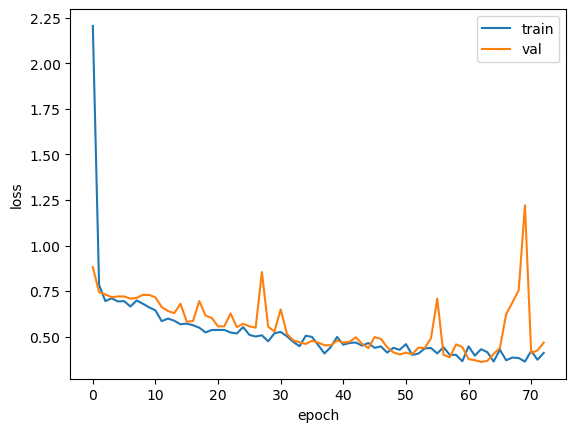

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])

In [12]:
from sklearn.metrics import classification_report
model.load_weights(checkpoint_filepath)
y_preds = model.predict({
                        'text_embeddings': dict(X_test_tokenized), 
                        'image_embeddings': X_image_test,
                        'audio_embeddings': X_audio_test}
                                        , batch_size=1)
y_true=np.argmax(y_test, axis=1)
predictions = np.argmax(y_preds, axis=1)


35/35 [==============================] - 4s 36ms/step


In [13]:
y_true

array([0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

In [14]:
predictions

array([0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0])

In [15]:
from sklearn.metrics import classification_report
print(classification_report(predictions, y_true))

              precision    recall  f1-score   support

           0       0.67      0.86      0.75        14
           1       0.88      0.71      0.79        21

    accuracy                           0.77        35
   macro avg       0.77      0.79      0.77        35
weighted avg       0.80      0.77      0.77        35

